In [ ]:
##### Use tensorboard
#!pip install tensorboard
#!pip uninstall tensorflow
#!rm -rf ~/anaconda3/lib/python3.8/site-packages/tensorflow
#!pip install tensorflow

##### model diagram
#!pip install --user pydot graphviz


In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import math

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
#import pydot
from keras.utils.vis_utils import plot_model
#from keras.layers import Bidirectional
#from keras.layers import Dropout
tf.random.set_seed(42)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-colorblind')
sns.set_theme()
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'figure.titlesize': 'x-large',
          'figure.dpi': 150,
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'savefig.bbox': 'tight'}

plt.rcParams.update(params)
# plt.rcParams.keys() ### Use to check the available parameters

In [2]:
%run ts_modelling.py

# Data load

In [3]:
df = pd.read_csv("NordPool/NO1/Spot_price_NO1.csv")
df = df[["price", "datetime"]]
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace = True)
data = df.iloc[:41592] # Keep untouched From October 2021


In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# General data normalization
p_min = data.min()
p_max = data.max()
ndata = (data-p_min)/(p_max-p_min)

# Modelling

## Model diagram

In [7]:
train_size = 1968
test_size = 96
folds = 20
n_steps_in = 168
n_steps_out = 96
indexes=[]
preds = []
for ii, tr, te in datagen(train_size, test_size, folds):
    # Define data
    in_seq = ndata[tr:te].values
    x_input = ndata[te-n_steps_in:te].values  # Last sequence of in_seq, to use for prediction
    y_true = ndata[te:te+n_steps_out] # Values to be predicted
    # convert to [rows, columns] structure
    in_seq = in_seq.reshape((len(in_seq), 1))
    #in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    #out_seq = out_seq.reshape((len(out_seq), 1))
    dataset=np.hstack((in_seq, in_seq))
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    n_features= X.shape[2]   
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(100, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')
    # fit model
        # Define the Keras TensorBoard callback.
        #logdir="logs/fit/" + dt.now().strftime("%Y%m%d-%H%M%S")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    print(X.shape,"\n")
    print(y.shape)
    model.fit(X, y, epochs=5, verbose=1)
    x_input = x_input.reshape((1, n_steps_in, n_features))
    model.predict(x_input, verbose = 0)
    #plot_model(model, to_file='Model_LSTM_2.png', show_shapes=True, show_layer_names=True)
    if ii == 1: break
    #with open(f'modelsummary_Fold_{ii}.txt', 'w') as f:
    #    model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    #preds.append([model.predict(x_input, verbose=0)]) # Save predictions for evaluation: rmse, mape...
    #with open(f"preds_fold_{ii}.txt", "w") as output:
    #    output.write(str(preds))   # Save predictions in case memory breaks
    #indexes.append([te, te+test_size]) # Save indexes for plotting

(1706, 168, 1) 

(1706, 96)
Epoch 1/5
54/54 [==============================] - 12s 151ms/step - loss: 0.0011
Epoch 2/5
54/54 [==============================] - 10s 180ms/step - loss: 2.7769e-04
Epoch 3/5
54/54 [==============================] - 12s 217ms/step - loss: 2.4619e-04
Epoch 4/5
54/54 [==============================] - 14s 262ms/step - loss: 2.2930e-04
Epoch 5/5
54/54 [==============================] - 10s 193ms/step - loss: 2.1860e-04


## Improving

In [35]:
train_size = 1968
test_size = 96
folds = 20
n_steps_in = 168
n_steps_out = 96
indexes=[]
preds = []
for ii, tr, te in datagen(train_size, test_size, folds):
    # Define data
    in_seq = ndata[tr:te].values
    x_input = ndata[te-n_steps_in:te].values  # Last sequence of in_seq, to use for prediction
    y_true = ndata[te:te+n_steps_out] # Values to be predicted
    # convert to [rows, columns] structure
    in_seq = in_seq.reshape((len(in_seq), 1))
    #in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    #out_seq = out_seq.reshape((len(out_seq), 1))
    dataset=np.hstack((in_seq, in_seq))
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    n_features= X.shape[2]   
    model = Sequential()
    model.add(LSTM(168, input_shape=(n_steps_in, n_features), return_sequences=True))
    #model.add(RepeatVector(n_steps_out))
    #model.add(LSTM(100, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(n_steps_out)) # Since it is not a batch-like processing,
                                  # the output needs to be of the correct time-steps.
    model.compile(optimizer='adam', loss='mse')
    # fit model
        # Define the Keras TensorBoard callback.
        #logdir="logs/fit/" + dt.now().strftime("%Y%m%d-%H%M%S")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    print(X.shape,"\n")
    print(y.shape)
    model.fit(X, y, epochs=150, verbose=1)
    x_input = x_input.reshape((1, n_steps_in, n_features))
    #model.predict(x_input, verbose = 0)
    #plot_model(model, to_file='Model_LSTM_2.png', show_shapes=True, show_layer_names=True)
    
    #with open(f'modelsummary_Fold_{ii}.txt', 'w') as f:
    #    model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    preds.append([model.predict(x_input, verbose=0)]) # Save predictions for evaluation: rmse, mape...
    #with open(f"preds_fold_{ii}.txt", "w") as output:
    #    output.write(str(preds))   # Save predictions in case memory breaks
    indexes.append([te, te+test_size]) # Save indexes for plotting
    if ii == 2: break

(1706, 168, 1) 

(1706, 96)
Epoch 1/150
54/54 [==============================] - 14s 224ms/step - loss: 8.0489e-04
Epoch 2/150
54/54 [==============================] - 16s 289ms/step - loss: 2.5352e-04
Epoch 3/150
54/54 [==============================] - 17s 308ms/step - loss: 2.3528e-04
Epoch 4/150
54/54 [==============================] - 16s 303ms/step - loss: 2.0834e-04
Epoch 5/150
54/54 [==============================] - 15s 270ms/step - loss: 1.9347e-04
Epoch 6/150
54/54 [==============================] - 15s 276ms/step - loss: 1.8273e-04
Epoch 7/150
54/54 [==============================] - 16s 302ms/step - loss: 1.7456e-04
Epoch 8/150
54/54 [==============================] - 16s 298ms/step - loss: 1.7179e-04
Epoch 9/150
54/54 [==============================] - 15s 275ms/step - loss: 1.6692e-04
Epoch 10/150
54/54 [==============================] - 15s 276ms/step - loss: 1.6607e-04
Epoch 11/150
54/54 [==============================] - 15s 278ms/step - loss: 1.7585e-04
Epoch 12/150


54/54 [==============================] - 14s 264ms/step - loss: 1.5146e-04
Epoch 94/150
54/54 [==============================] - 14s 265ms/step - loss: 1.5119e-04
Epoch 95/150
54/54 [==============================] - 14s 262ms/step - loss: 1.5196e-04
Epoch 96/150
54/54 [==============================] - 14s 264ms/step - loss: 1.5387e-04
Epoch 97/150
54/54 [==============================] - 14s 263ms/step - loss: 1.5236e-04
Epoch 98/150
54/54 [==============================] - 15s 272ms/step - loss: 1.5176e-04
Epoch 99/150
54/54 [==============================] - 14s 265ms/step - loss: 1.5111e-04
Epoch 100/150
54/54 [==============================] - 14s 262ms/step - loss: 1.5318e-04
Epoch 101/150
54/54 [==============================] - 14s 262ms/step - loss: 1.5261e-04
Epoch 102/150
54/54 [==============================] - 14s 265ms/step - loss: 1.5197e-04
Epoch 103/150
54/54 [==============================] - 14s 263ms/step - loss: 1.5394e-04
Epoch 104/150
54/54 [====================

54/54 [==============================] - 17s 309ms/step - loss: 1.8204e-04
Epoch 36/150
54/54 [==============================] - 15s 275ms/step - loss: 1.7624e-04
Epoch 37/150
54/54 [==============================] - 19s 346ms/step - loss: 1.8758e-04
Epoch 38/150
54/54 [==============================] - 15s 270ms/step - loss: 1.9468e-04
Epoch 39/150
54/54 [==============================] - 15s 276ms/step - loss: 1.8532e-04
Epoch 40/150
54/54 [==============================] - 16s 290ms/step - loss: 1.8013e-04
Epoch 41/150
54/54 [==============================] - 15s 273ms/step - loss: 1.7705e-04
Epoch 42/150
54/54 [==============================] - 16s 288ms/step - loss: 1.7725e-04
Epoch 43/150
54/54 [==============================] - 15s 282ms/step - loss: 1.7452e-04
Epoch 44/150
54/54 [==============================] - 14s 263ms/step - loss: 1.8187e-04
Epoch 45/150
54/54 [==============================] - 19s 353ms/step - loss: 1.7384e-04
Epoch 46/150
54/54 [=========================

Epoch 128/150
54/54 [==============================] - 15s 282ms/step - loss: 1.6172e-04
Epoch 129/150
54/54 [==============================] - 16s 301ms/step - loss: 1.6084e-04
Epoch 130/150
54/54 [==============================] - 15s 285ms/step - loss: 1.6232e-04
Epoch 131/150
54/54 [==============================] - 15s 285ms/step - loss: 1.5796e-04
Epoch 132/150
54/54 [==============================] - 17s 307ms/step - loss: 1.6015e-04
Epoch 133/150
54/54 [==============================] - 15s 285ms/step - loss: 1.5920e-04
Epoch 134/150
54/54 [==============================] - 16s 291ms/step - loss: 1.5826e-04
Epoch 135/150
54/54 [==============================] - 16s 287ms/step - loss: 1.5956e-04
Epoch 136/150
54/54 [==============================] - 16s 297ms/step - loss: 1.6384e-04
Epoch 137/150
54/54 [==============================] - 16s 299ms/step - loss: 1.5782e-04
Epoch 138/150
54/54 [==============================] - 21s 386ms/step - loss: 1.5838e-04
Epoch 139/150
54/54 [

In [47]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 168, 168)          114240    
                                                                 
 flatten_5 (Flatten)         (None, 28224)             0         
                                                                 
 dense_14 (Dense)            (None, 96)                2709600   
                                                                 
Total params: 2,823,840
Trainable params: 2,823,840
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.save(f'Plots/LSTM_3 Fold {ii+1}')

INFO:tensorflow:Assets written to: Plots/LSTM_3 Fold 2\assets


INFO:tensorflow:Assets written to: Plots/LSTM_3 Fold 2\assets


In [36]:
preds

[[array([[0.12005227, 0.11681215, 0.11678828, 0.11662106, 0.11801229,
          0.11691383, 0.11803967, 0.12012733, 0.12363981, 0.12954386,
          0.13157353, 0.13130608, 0.12900037, 0.12836367, 0.12598613,
          0.12499376, 0.12425929, 0.12409697, 0.1262377 , 0.12691368,
          0.12997602, 0.13214198, 0.13177136, 0.13049877, 0.12945192,
          0.13014218, 0.12792245, 0.12881285, 0.12770718, 0.12577659,
          0.12467353, 0.12795366, 0.13237008, 0.13850388, 0.14134985,
          0.14067686, 0.13943365, 0.13495368, 0.13088936, 0.12870038,
          0.13088918, 0.13052922, 0.13082613, 0.13305333, 0.13398889,
          0.13324448, 0.13111278, 0.13104948, 0.12839991, 0.12677659,
          0.12616304, 0.12673464, 0.12759376, 0.12738547, 0.12857036,
          0.13070732, 0.13732217, 0.1411817 , 0.14320758, 0.1413872 ,
          0.14019604, 0.13538755, 0.13370563, 0.13277376, 0.12927146,
          0.12790602, 0.13083439, 0.13215567, 0.13234091, 0.13003293,
          0.12888081

## Data checks

In [75]:
in_seq

array([[29.36],
       [29.4 ],
       [28.91],
       ...,
       [30.05],
       [29.83],
       [29.5 ]])

In [76]:
x_input.size

168

In [77]:
out_seq.size # Number of sequences in each fold

10

In [78]:
out_seq[0].size # Check size of each array

1

In [79]:
X   # Number of aarrays depends on number of features
# Array format allows to have other input features (exog)

array([[[29.36],
        [29.4 ],
        [28.91],
        ...,
        [30.83],
        [30.95],
        [30.55]],

       [[29.4 ],
        [28.91],
        [28.11],
        ...,
        [30.95],
        [30.55],
        [29.89]],

       [[28.91],
        [28.11],
        [28.24],
        ...,
        [30.55],
        [29.89],
        [29.56]],

       ...,

       [[30.74],
        [30.18],
        [29.71],
        ...,
        [31.04],
        [30.56],
        [29.91]],

       [[30.18],
        [29.71],
        [29.25],
        ...,
        [30.56],
        [29.91],
        [29.72]],

       [[29.71],
        [29.25],
        [28.88],
        ...,
        [29.91],
        [29.72],
        [29.39]]])

In [80]:
X[0].size

168

In [69]:
y

array([[30.55, 29.89, 29.56, ..., 29.88, 29.5 , 29.43],
       [29.89, 29.56, 29.11, ..., 29.5 , 29.43, 29.21],
       [29.56, 29.11, 28.99, ..., 29.43, 29.21, 28.83],
       ...,
       [29.91, 29.72, 29.39, ..., 31.38, 30.66, 30.05],
       [29.72, 29.39, 29.52, ..., 30.66, 30.05, 29.83],
       [29.39, 29.52, 29.42, ..., 30.05, 29.83, 29.5 ]])

In [67]:
y[0].size

96

In [71]:
n_features

168

In [72]:
n_features=X.shape[2]

In [73]:
n_features

1

## Evaluation

### De-Normalization

In [37]:
# Remove list(array(list(list(value))) structure...
predsd = [(val * (p_max - p_min) + p_min) for matrix in preds
          for sublist in matrix
          for subsublist in sublist
          for val in subsublist]
         #for val in arr]
# Correct number of folds -> Match folds performed prediction
predsd = [[predsd[j] for j in range(96)] for i in range(2)]
predsd

[[price    29.09342
  dtype: float64,
  price    28.261521
  dtype: float64,
  price    28.255392
  dtype: float64,
  price    28.212458
  dtype: float64,
  price    28.569657
  dtype: float64,
  price    28.287627
  dtype: float64,
  price    28.576685
  dtype: float64,
  price    29.112691
  dtype: float64,
  price    30.01452
  dtype: float64,
  price    31.530385
  dtype: float64,
  price    32.051503
  dtype: float64,
  price    31.982837
  dtype: float64,
  price    31.390844
  dtype: float64,
  price    31.227372
  dtype: float64,
  price    30.616939
  dtype: float64,
  price    30.362149
  dtype: float64,
  price    30.173573
  dtype: float64,
  price    30.131898
  dtype: float64,
  price    30.681531
  dtype: float64,
  price    30.855088
  dtype: float64,
  price    31.641343
  dtype: float64,
  price    32.197453
  dtype: float64,
  price    32.102296
  dtype: float64,
  price    31.775558
  dtype: float64,
  price    31.506779
  dtype: float64,
  price    31.684005
  dtyp

In [39]:
indexes # Check

[[1968, 2064], [4032, 4128]]

### Plotting

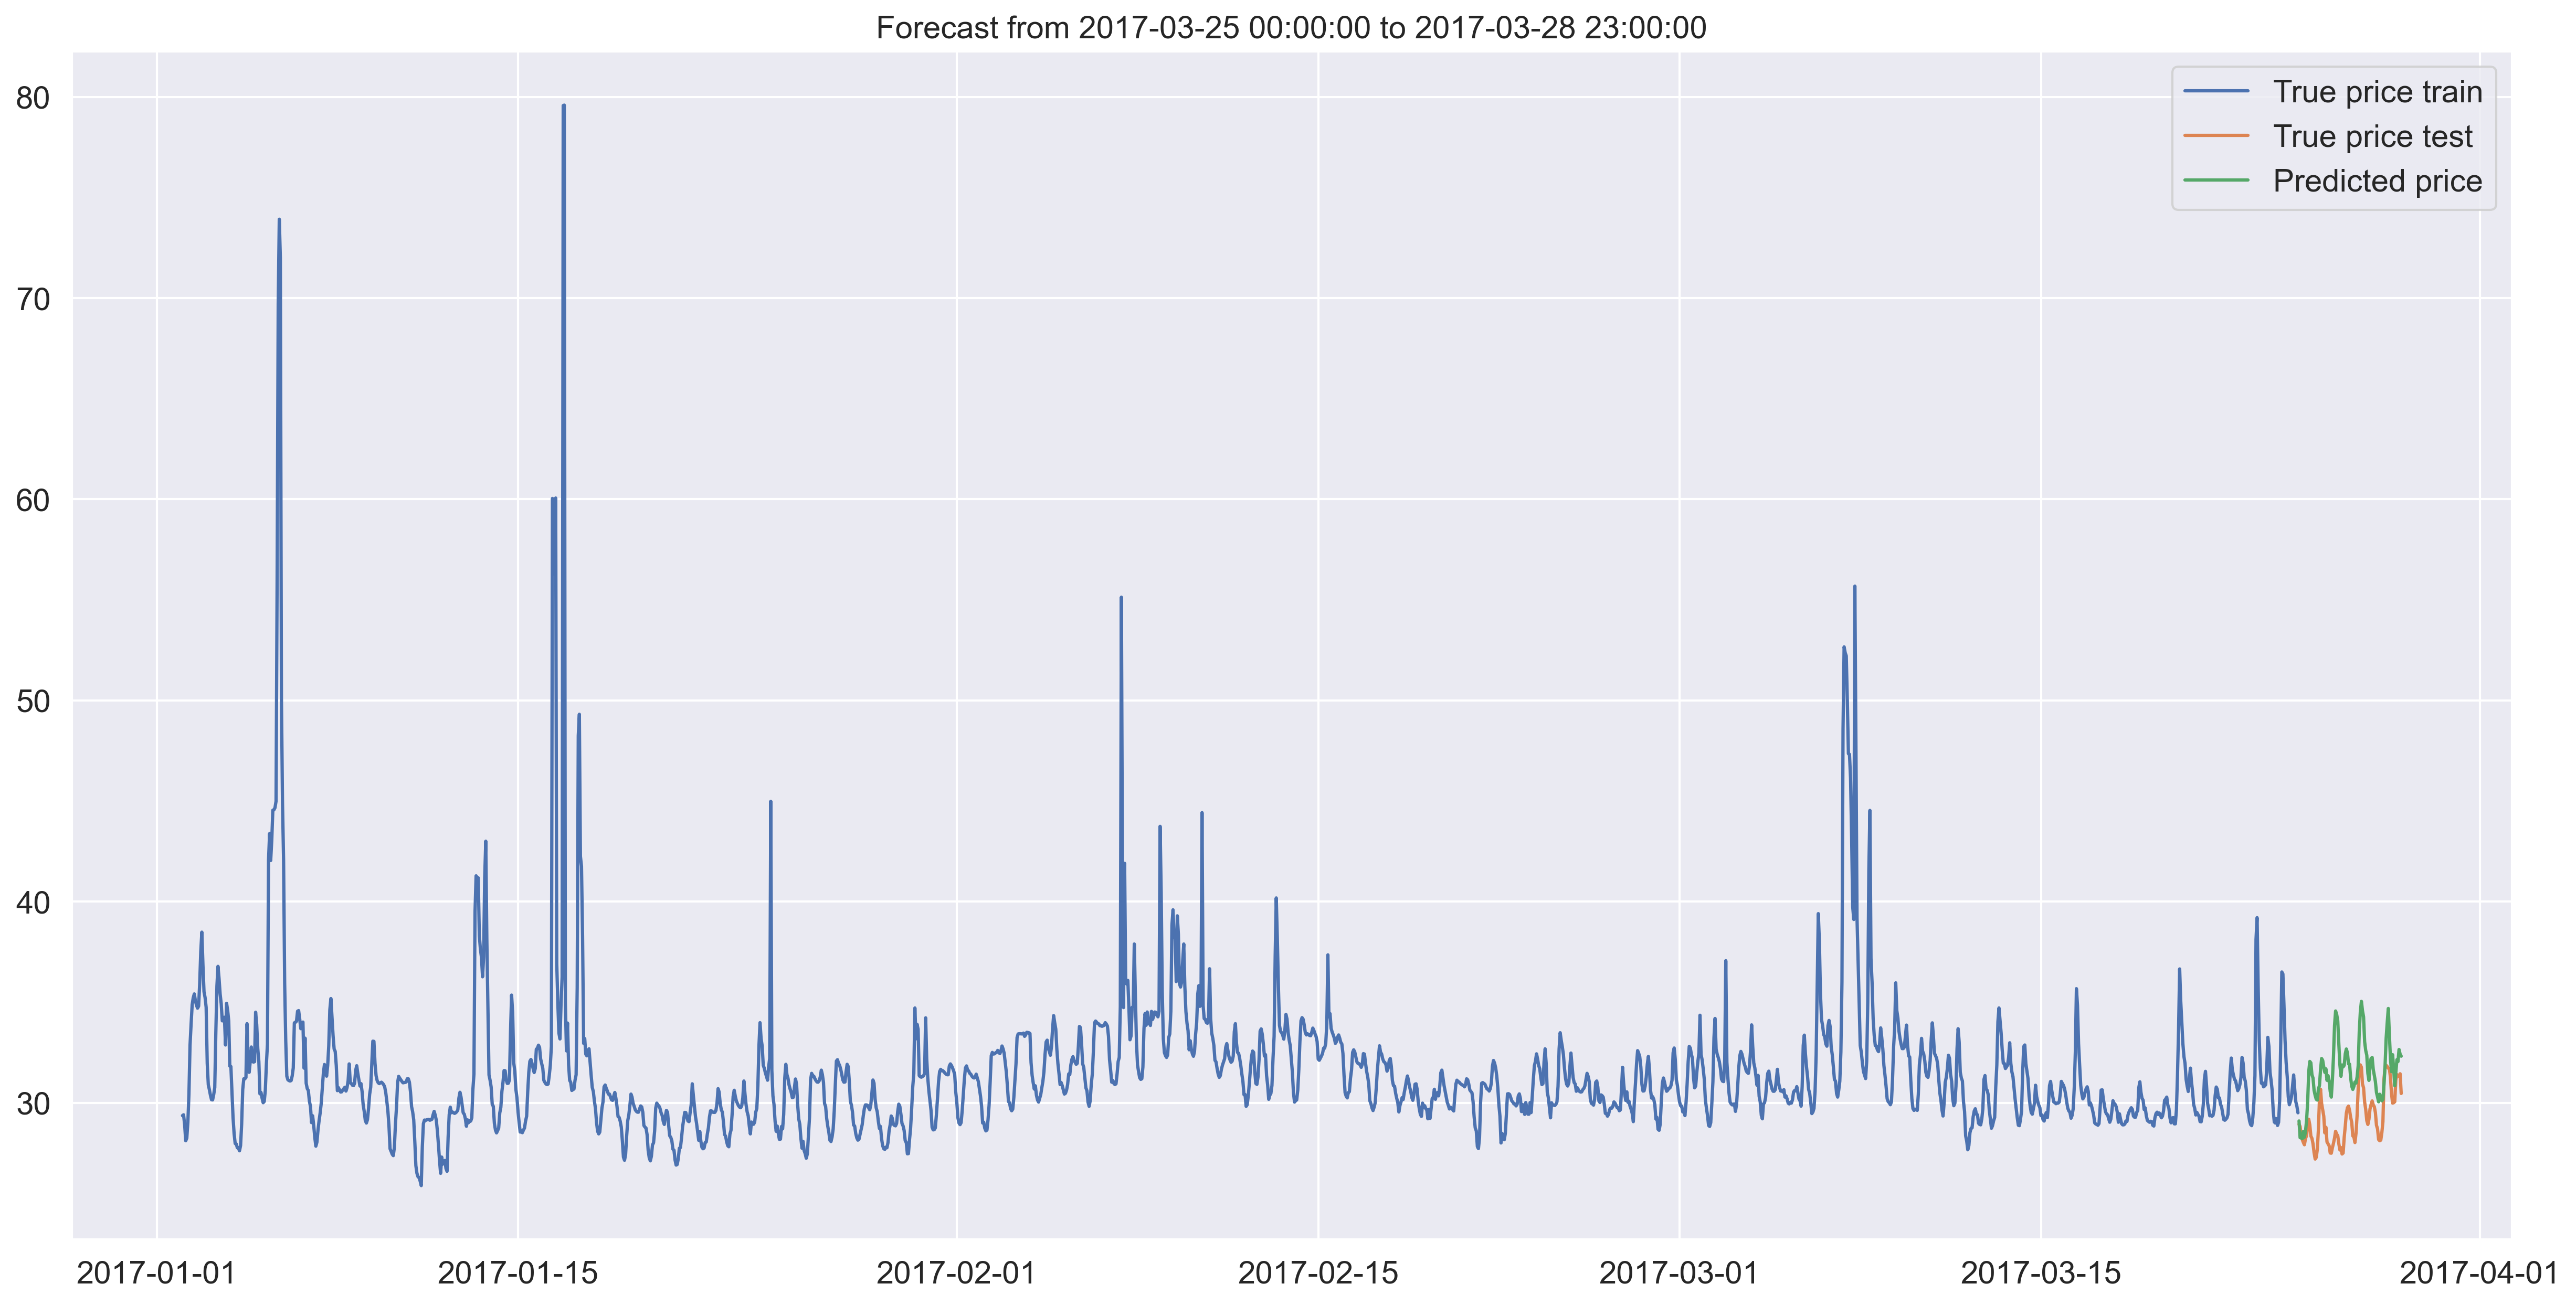

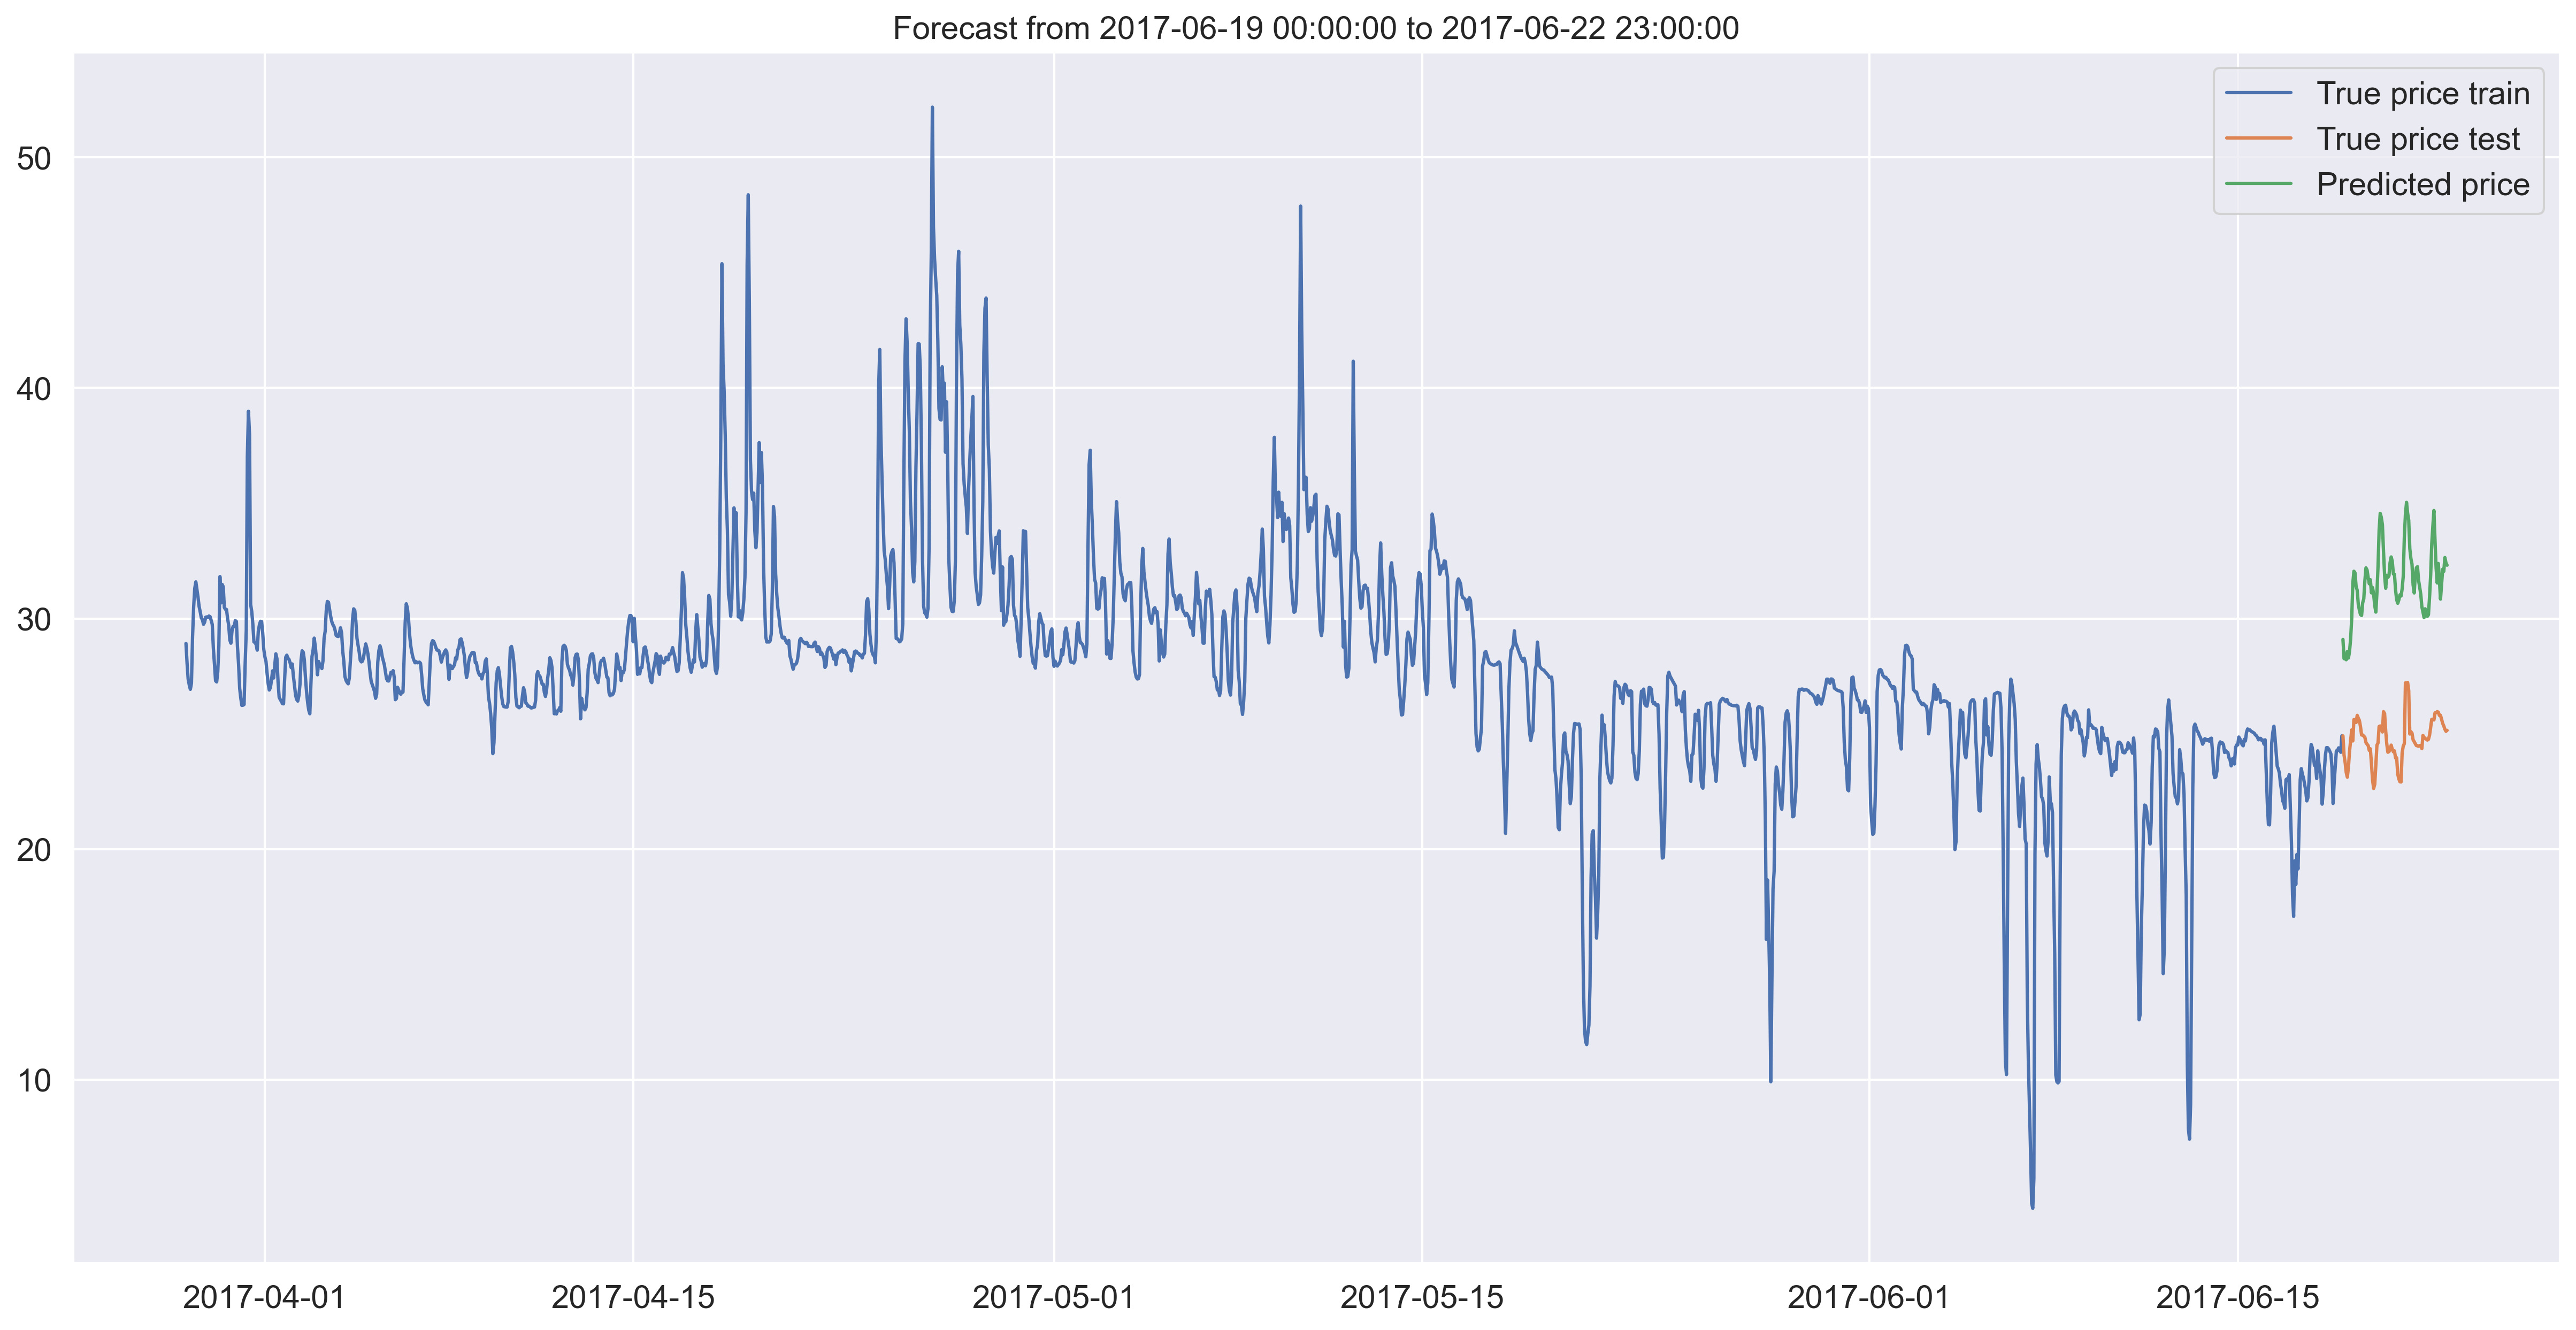

In [43]:
plt.rcParams.update(params)

for ii in range(2):
#    if ii == 3:
#        break
    fig = plt.figure(figsize=(20,10))
    plt.plot(data[(indexes[ii][0]-train_size):indexes[ii][0]], label = "True price train")
    plt.plot(data[indexes[ii][0]:indexes[ii][1]], label = "True price test")
    #len(data[indexes[0][0]:indexes[0][1]].index)
    plt.plot(data[indexes[ii][0]:indexes[ii][1]].index, predsd[ii], label = "Predicted price")
    plt.title(f'Forecast from {data[indexes[ii][0]:indexes[ii][1]].index[0]} to {data[indexes[ii][0]:indexes[ii][1]].index[-1]}')
    plt.legend()
    #fig.savefig(f'Plots/Pred LSTM_2 Fold {ii+1}.jpg')
    plt.show()   

### RMSE

In [45]:
###### De-normalized RMSE ######
rmse = []
rmse = [(np.sqrt(mean_squared_error(
    data[indexes[ii][0]:indexes[ii][1]], predsd[ii])))
                 for ii in range(2)]
rmse[0] # Check that it is not in the 0.01 range

2.681545793294653

Fold 1 has  a MAPE of 8.07 % and an RMSE of 2.6815
Fold 2 has  a MAPE of 27.36 % and an RMSE of 6.884
 Average MAPE: 17.715
 Average RMSE: 4.782784856533405


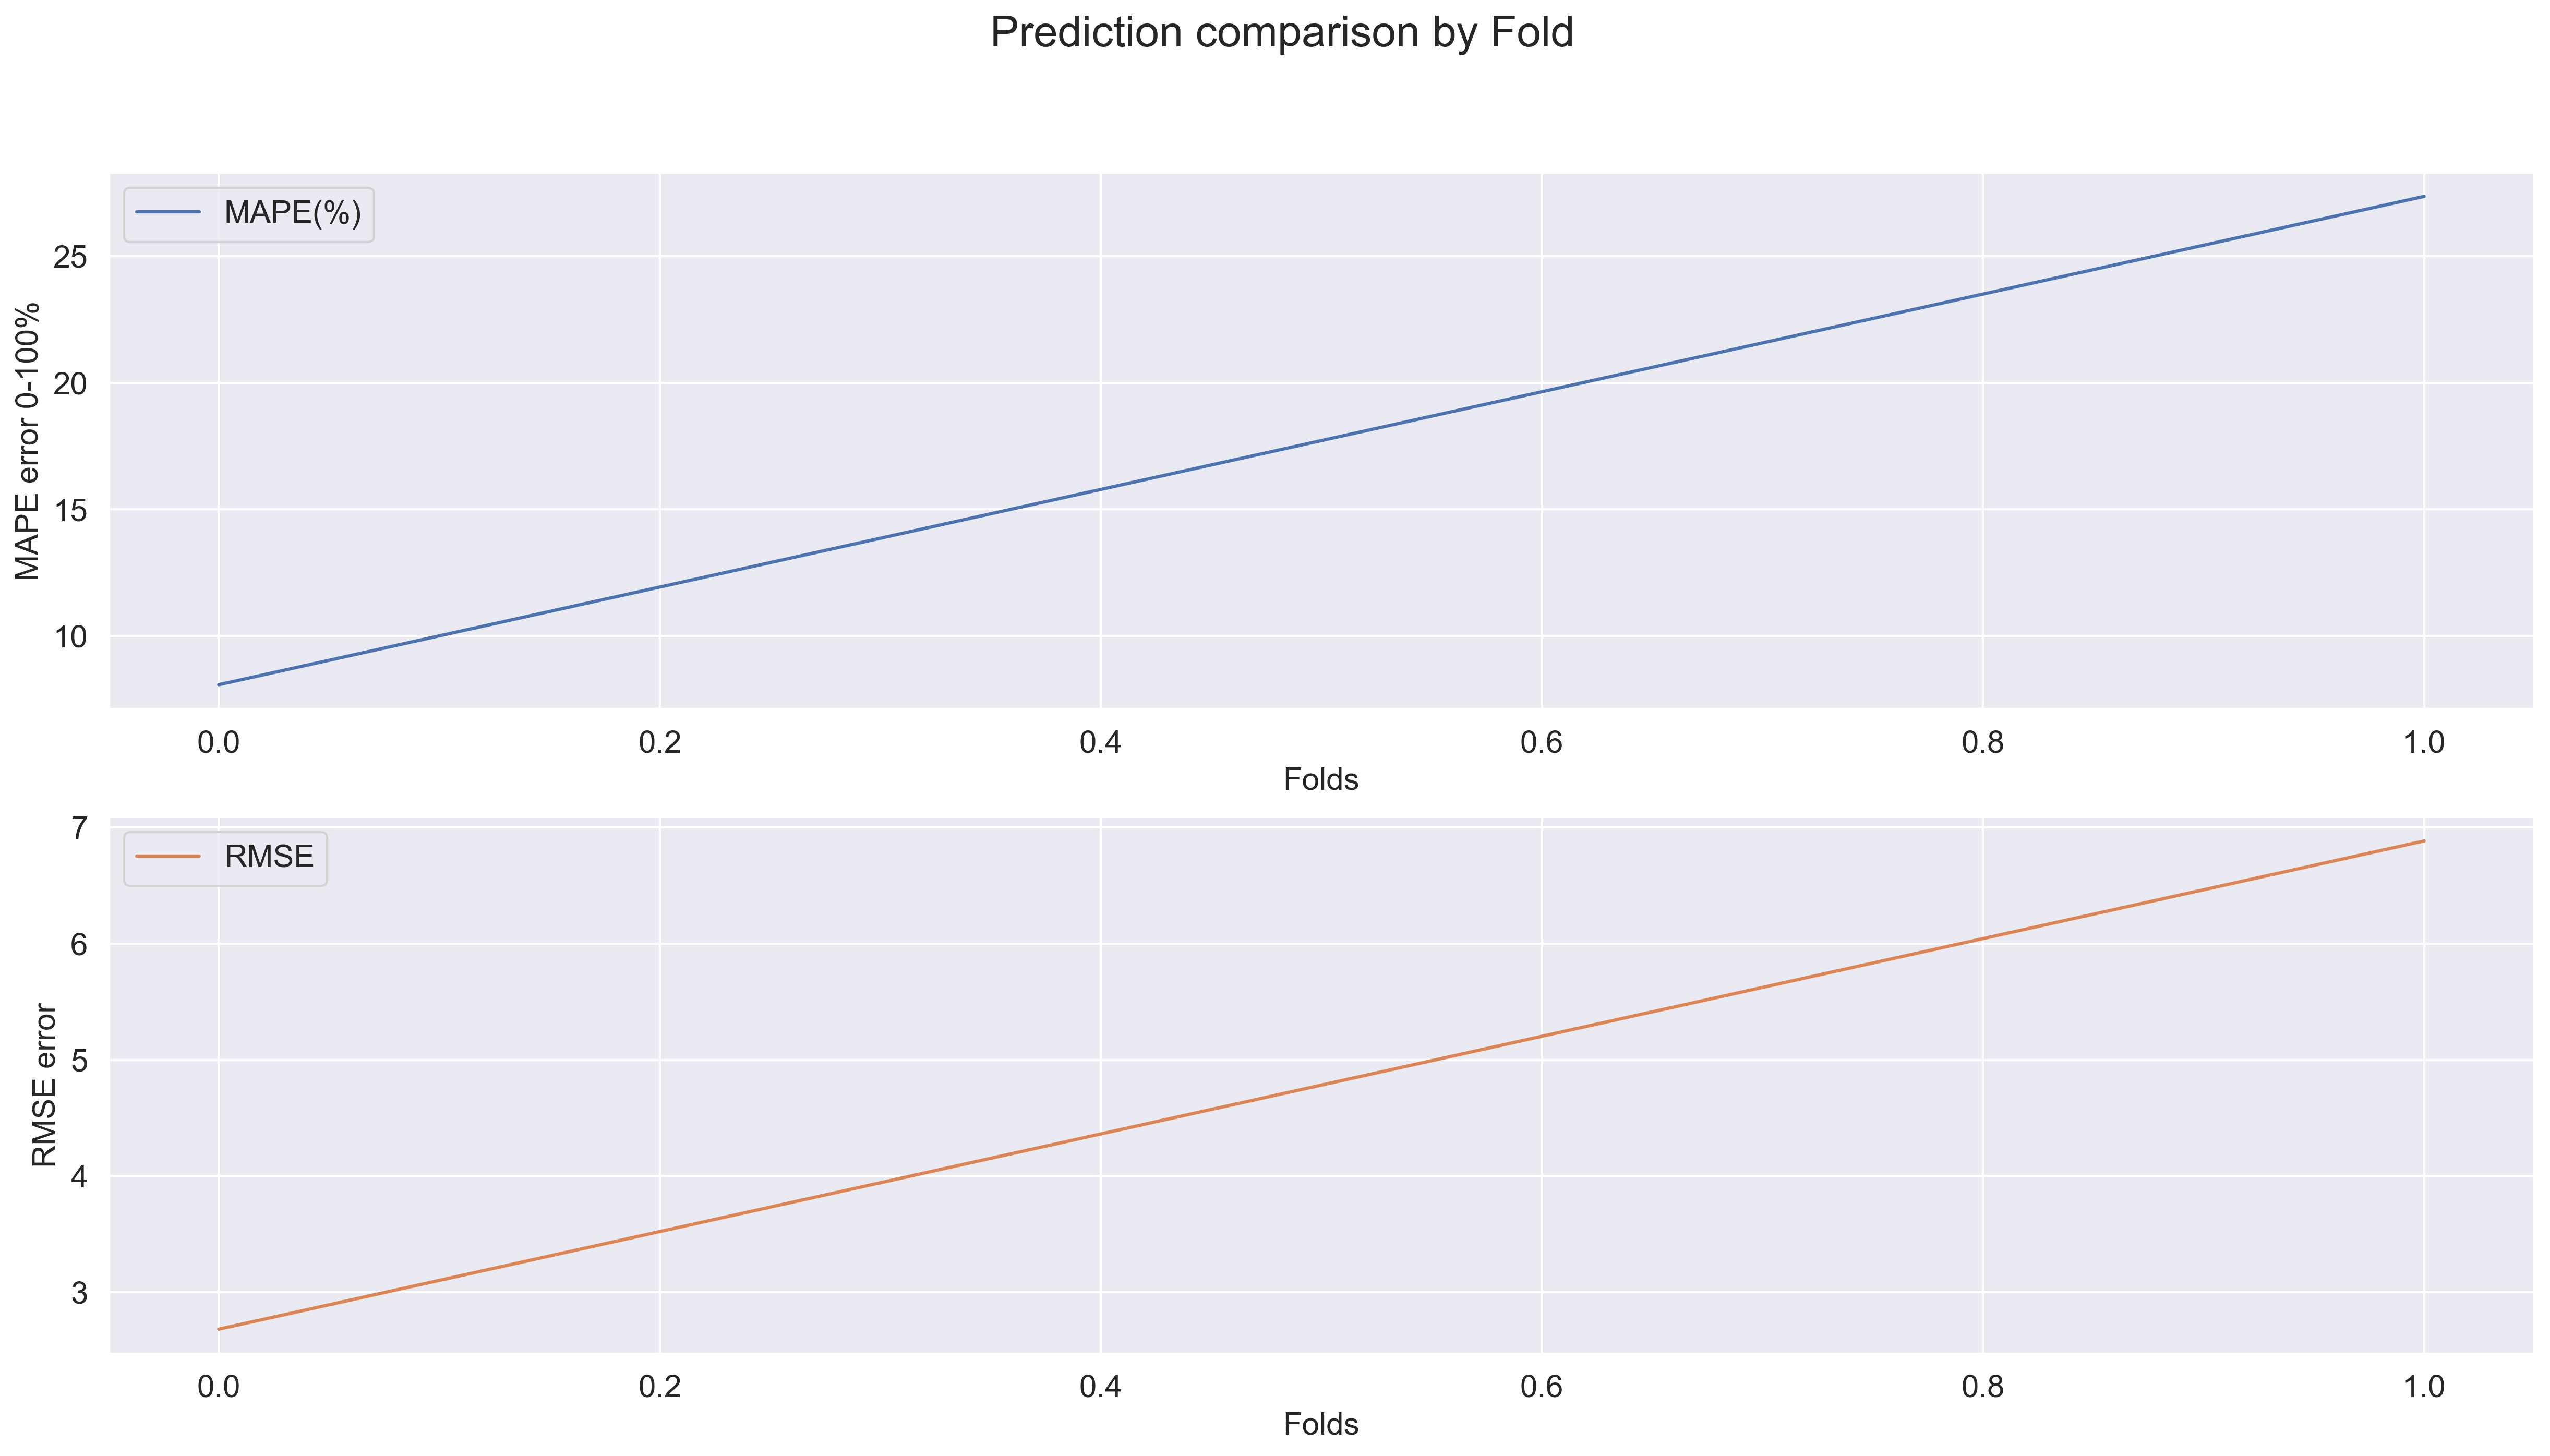

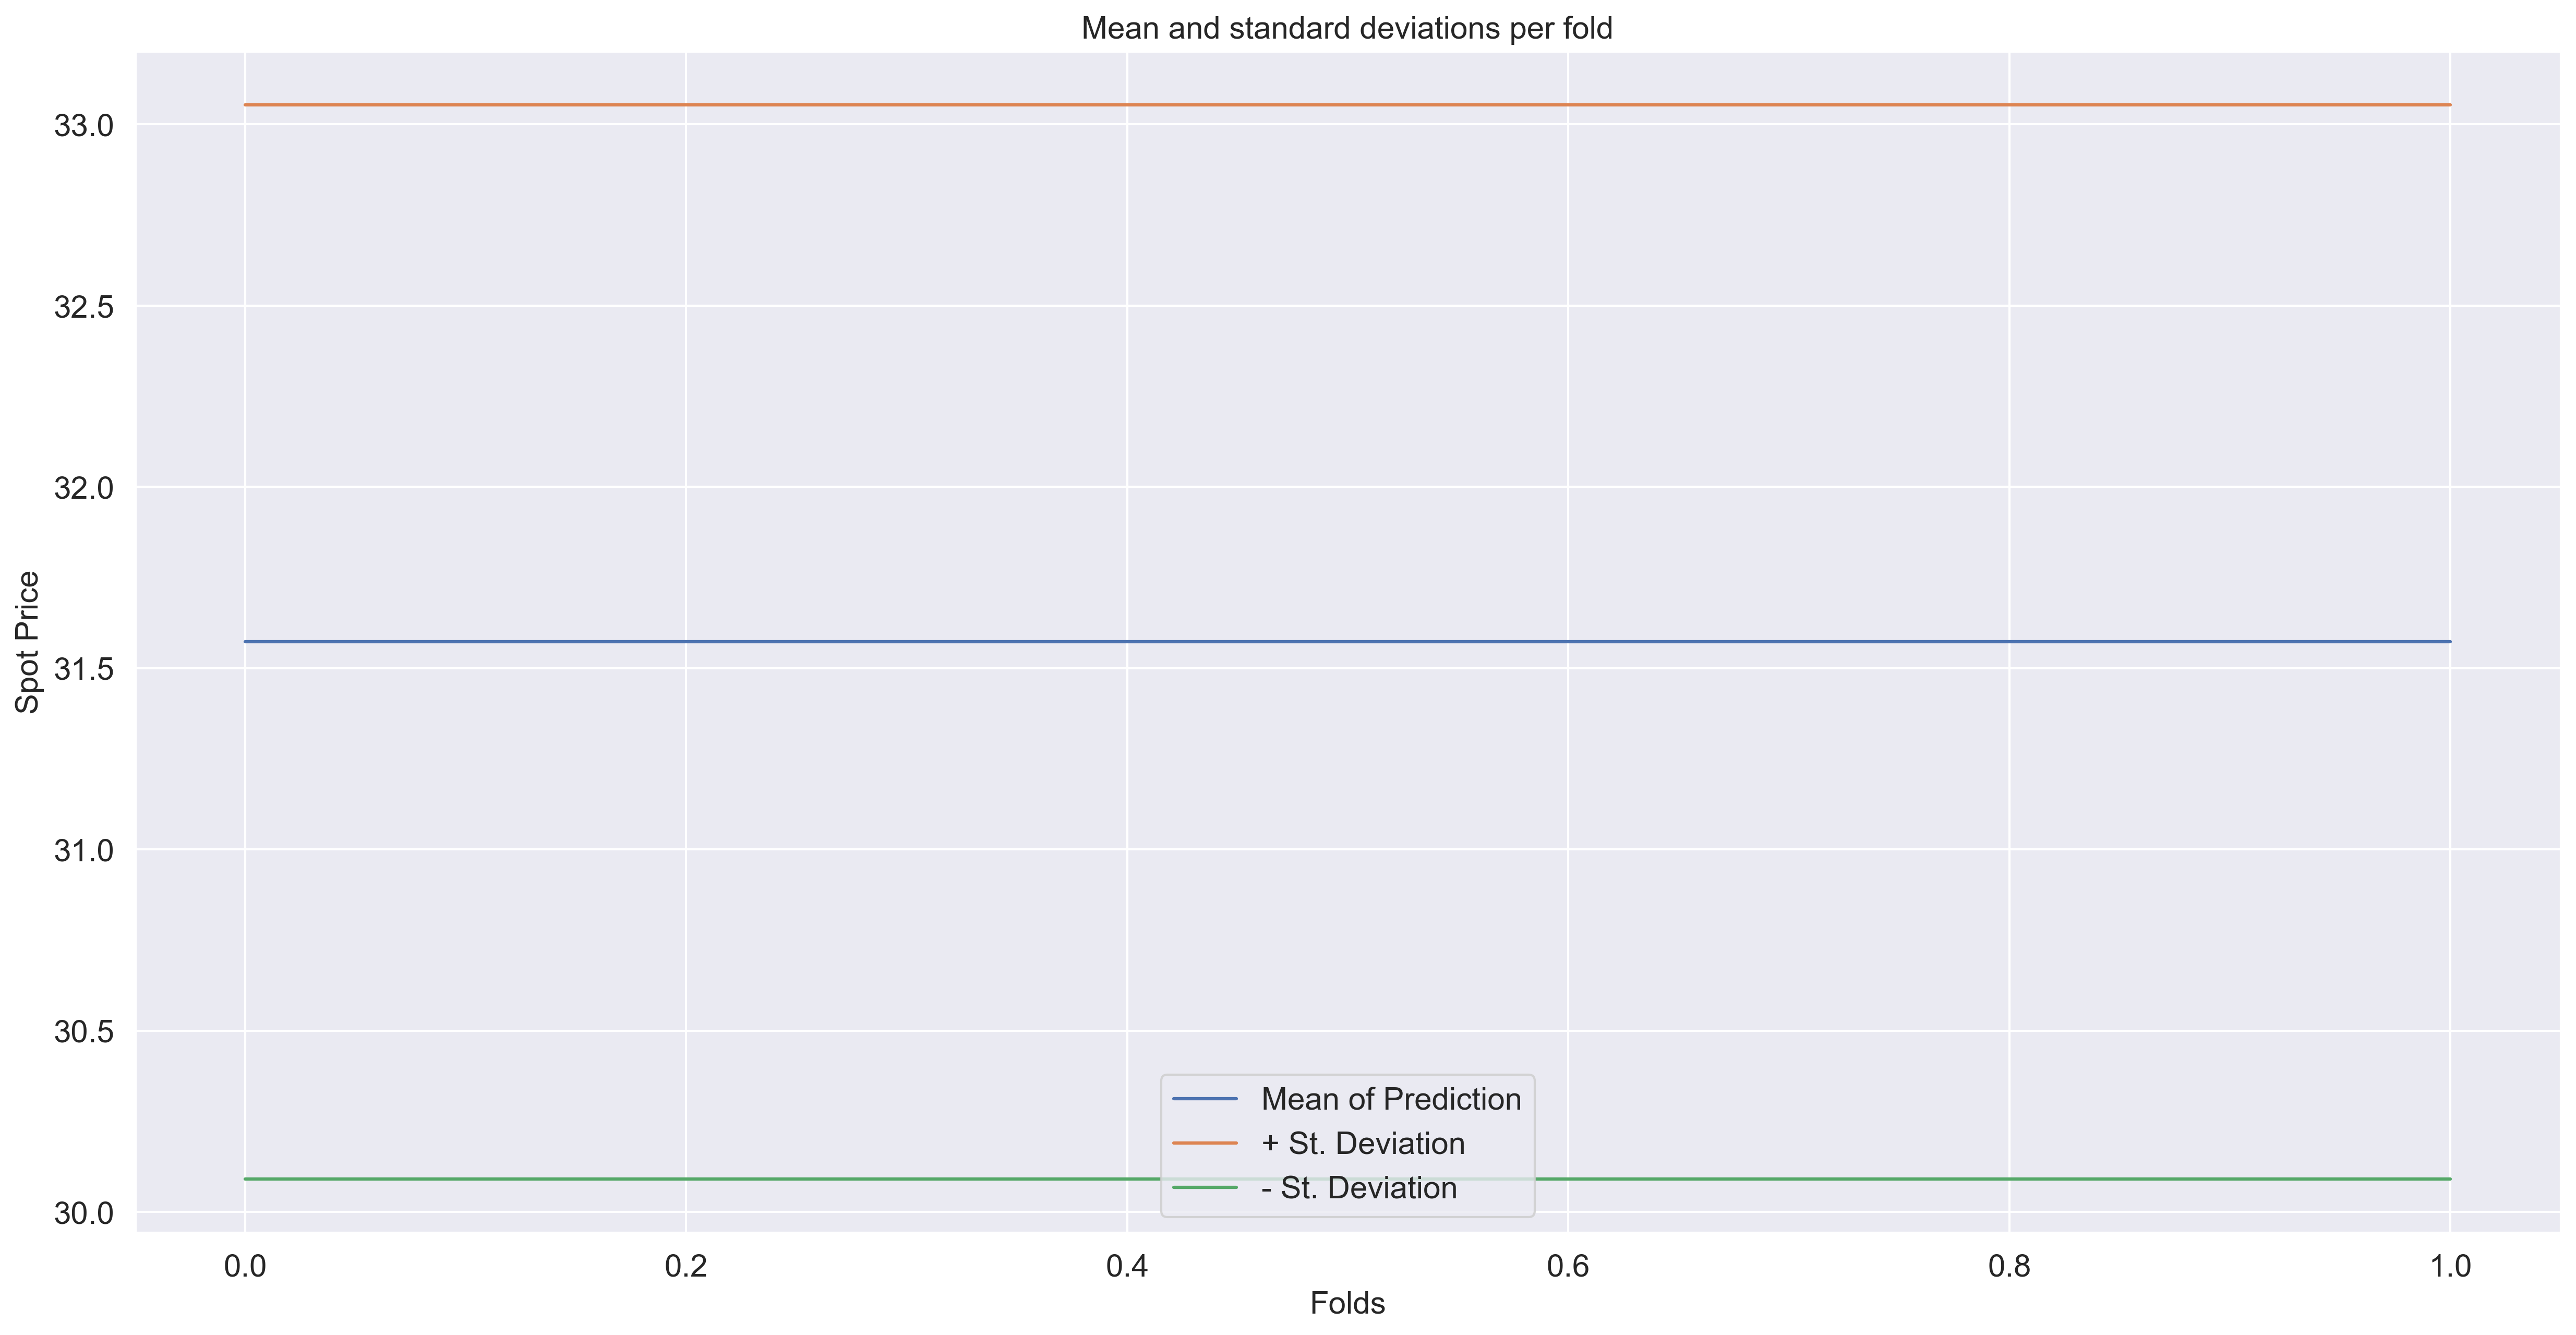

In [46]:
mape =[]
means = []
stdup = []
stddown = []
for ii in range(2):
    val = calculate_mape(data[indexes[ii][0]:indexes[ii][1]], predsd[ii])
    mape.append(val)
    means.append(np.mean(predsd[ii]))
    stdup.append(np.mean(predsd[ii]) + np.std(predsd[ii]))
    stddown.append(np.mean(predsd[ii]) - np.std(predsd[ii]))
    print(f'Fold {ii+1} has  a MAPE of {val} % and an RMSE of {round(rmse[ii], 4)}')
print(f' Average MAPE: {np.mean(mape)}')
print(f' Average RMSE: {np.mean(rmse)}')

plt.rcParams.update(params)

###### Error Plots ######    
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.suptitle("Prediction comparison by Fold", fontsize=20)
ax1.set_xlabel('Folds')
ax1.set_ylabel('MAPE error 0-100%')
#a, = ax1.plot(mape, "C0", label = "MAPE(%)")
ax1.plot(mape, "C0", label = "MAPE(%)")
ax1.legend(loc='best')
ax2.plot(rmse, "C1", label = "RMSE")
ax2.set_ylabel("RMSE error")
ax2.set_xlabel("Folds")
ax2.legend(loc='best')
plt.savefig(f'Plots/Pred LSTM_2 Errors per Fold.jpg')
plt.show()

###### Prediction Plots ######
fig3, ax3 = plt.subplots()   
ax3.set_xlabel('Folds') 
ax3.set_ylabel('Spot Price') 
ax3.plot(means, label = "Mean of Prediction")
ax3.plot((stdup), label = "+ St. Deviation")
ax3.plot((stddown), label = "- St. Deviation")
plt.title("Mean and standard deviations per fold")
plt.legend()
plt.savefig(f'Plots/Pred LSTM_2 Mean and standard deviation.jpg')
plt.show()

### Time-related

In [19]:
preds_values = [val for matrix in predsd
          for sublist in matrix
         for val in sublist]
preds_idx = [data[idx_rng[0]:idx_rng[1]].index for idx_rng in indexes]
preds_idx = [pd.to_datetime(val) for matrix in preds_idx
          for val in matrix]
#preds_idx

In [20]:
preds_df = pd.DataFrame(data=preds_values, index = preds_idx)
preds_df.reset_index(inplace = True)
preds_df.columns = ["datetime", "Predicted Price"]
preds_df["hour"] = preds_df["datetime"].dt.hour
preds_df["dayofweek"] = preds_df["datetime"].dt.weekday
#true_test = data.reset_index()
preds_df = preds_df.merge(data, how = "left", on = "datetime")
# Square root of the incremental mean of the difference
preds_df["RMSE"] = np.sqrt(((preds_df["Predicted Price"] - preds_df.price)**2).expanding().mean()) 

In [21]:
folder = "Plots/"
subfolder = "LSTM_2/"
filename = "/Preds"
filetype = ".csv"
preds_df.to_csv(path_or_buf=folder+subfolder+filename+filetype)
preds_df.head() # Data check

,datetime,Predicted Price,hour,dayofweek,price,RMSE
0,2017-03-25 00:00:00,31.128286,0,5,28.93,2.198286
1,2017-03-25 01:00:00,31.119352,1,5,28.82,2.249387
2,2017-03-25 02:00:00,31.174024,2,5,28.34,2.459754
3,2017-03-25 03:00:00,31.191397,3,5,28.17,2.611514
4,2017-03-25 04:00:00,31.206812,4,5,28.03,2.733940


hour
0     11.267854
1     11.276577
2     11.287676
3     11.298846
4     11.311329
5     11.323633
6     11.331727
7     11.339945
8     11.351357
9     11.367407
10    11.381945
11    11.395489
12    11.408201
13    11.419682
14    11.431351
15    11.443870
16    11.457204
17    11.470361
18    11.484830
19    11.500703
20    11.514366
21    11.522889
22    11.529955
23    11.536512
Name: RMSE, dtype: float64

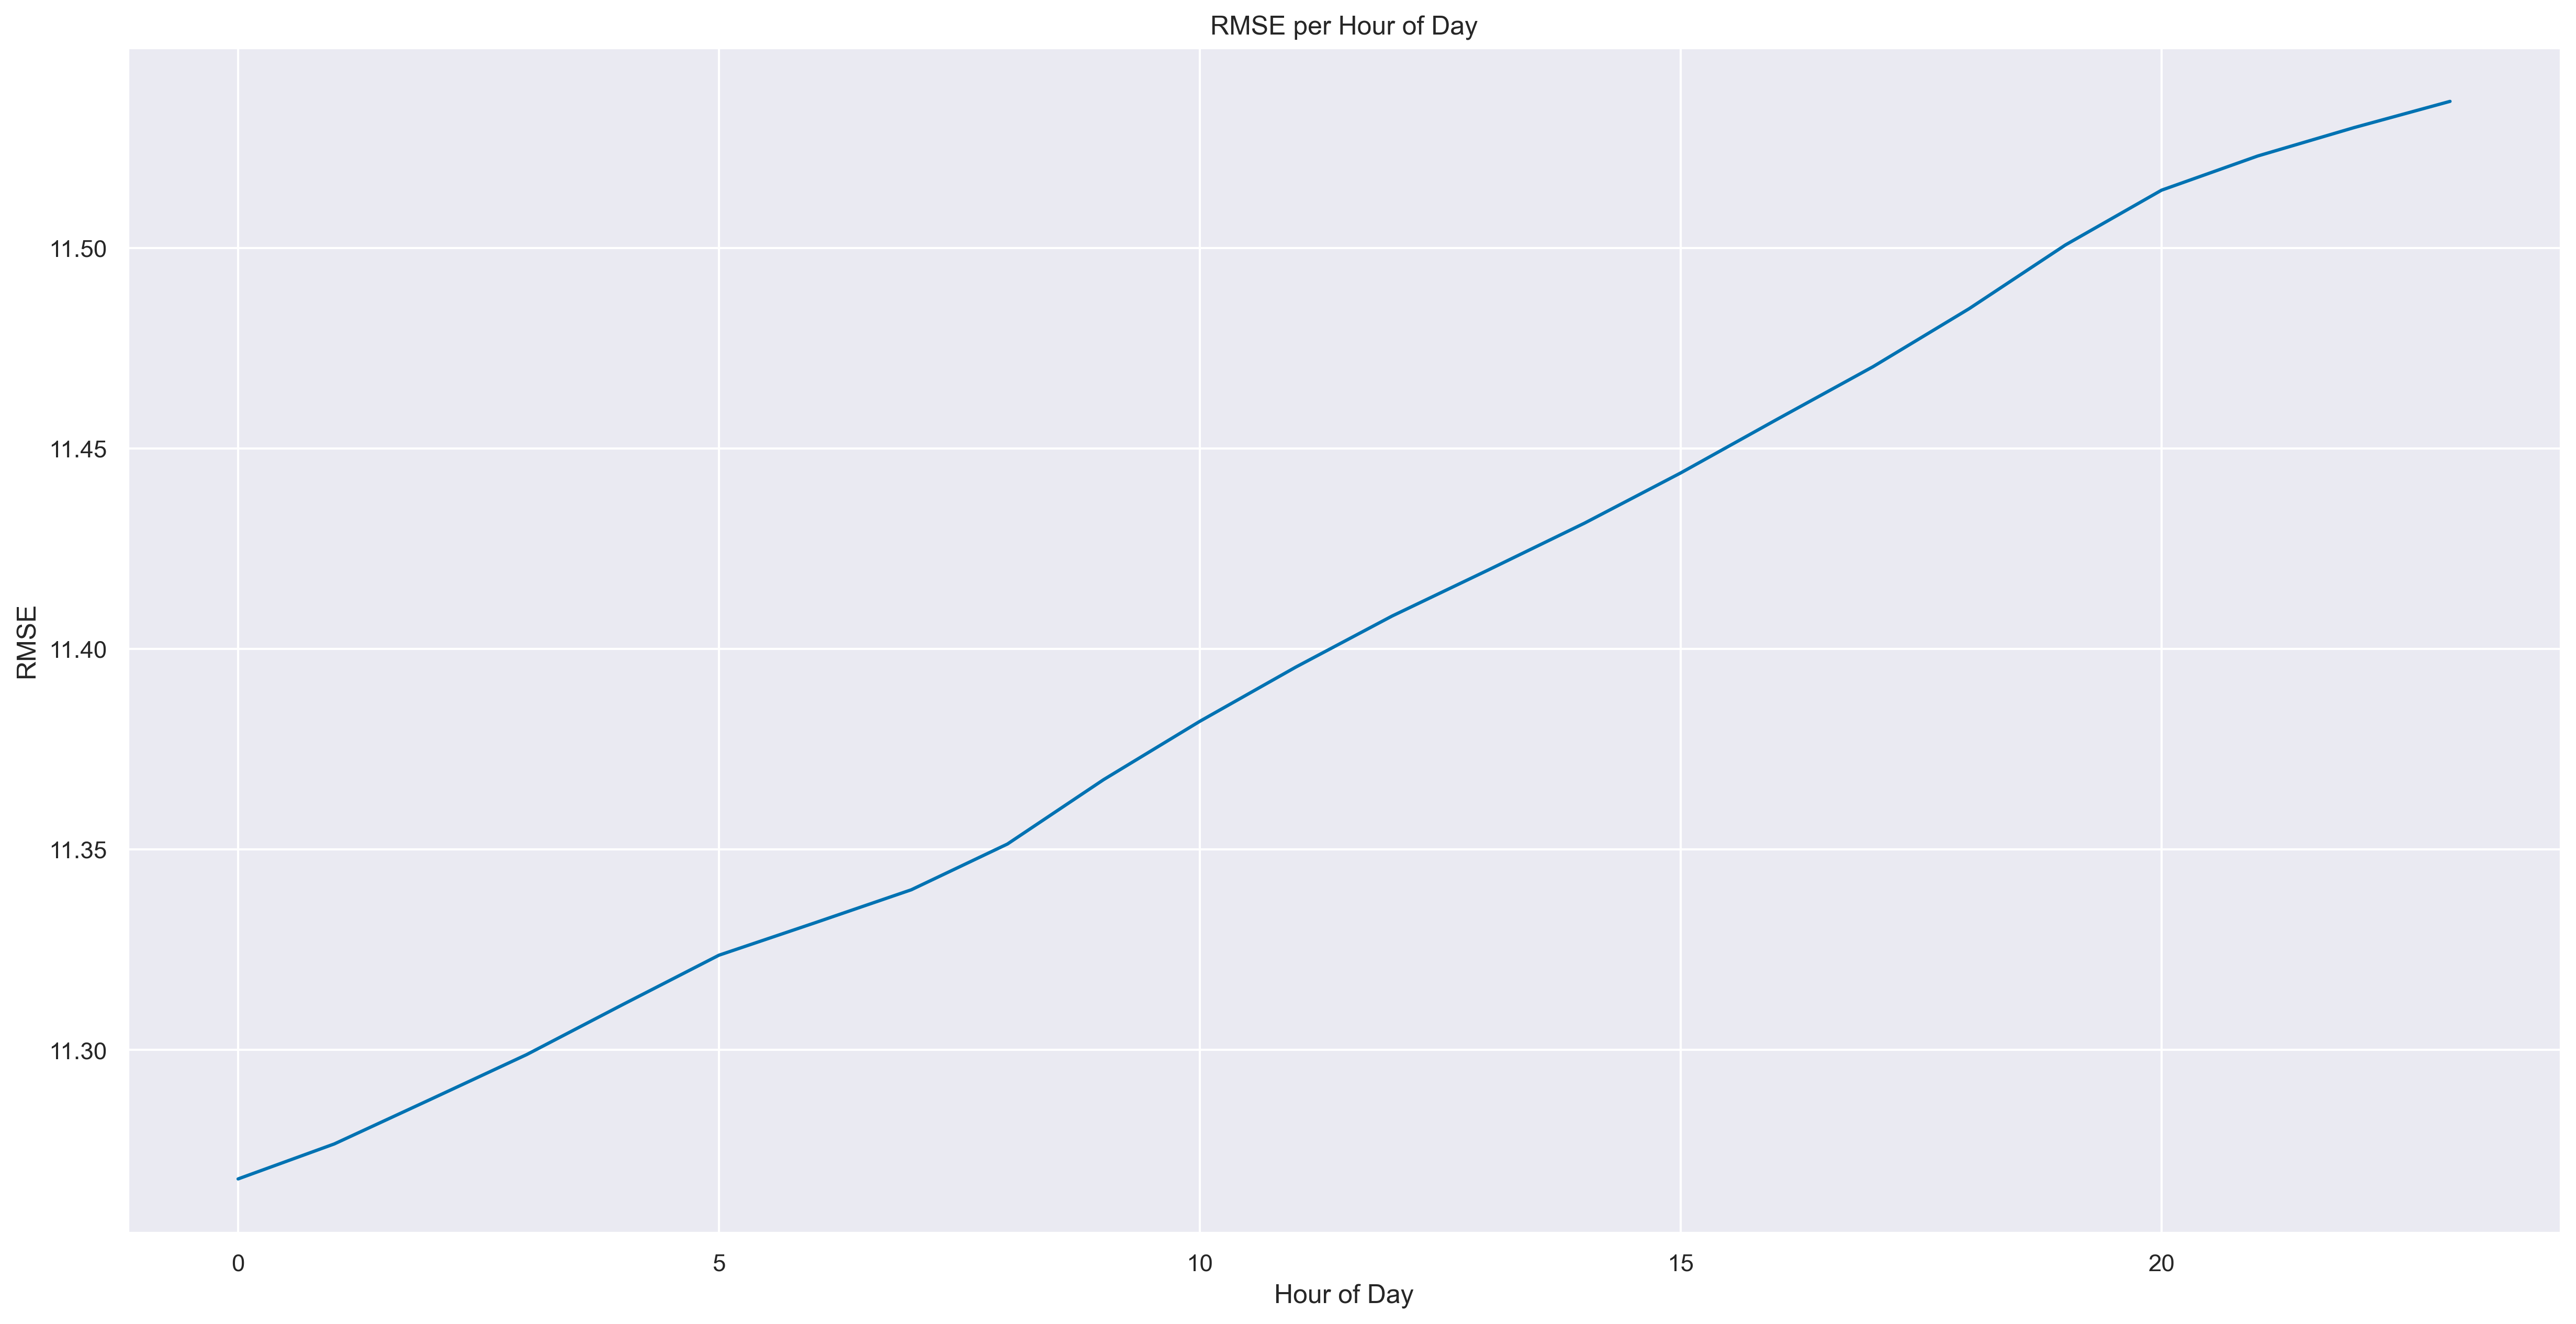

In [22]:
hour_preds = preds_df.groupby("hour")["RMSE"].mean()
display(hour_preds)
plt.plot(hour_preds,"C0")
plt.xlabel('Hour of Day') 
plt.ylabel('RMSE') 
plt.title("RMSE per Hour of Day")
plt.savefig(f'Plots/LSTM_2 Hourly error.jpg')
plt.show()

dayofweek
0    10.602326
1    11.335759
2    12.017822
3    12.050086
4    12.242195
5    10.727442
6    10.862836
Name: RMSE, dtype: float64

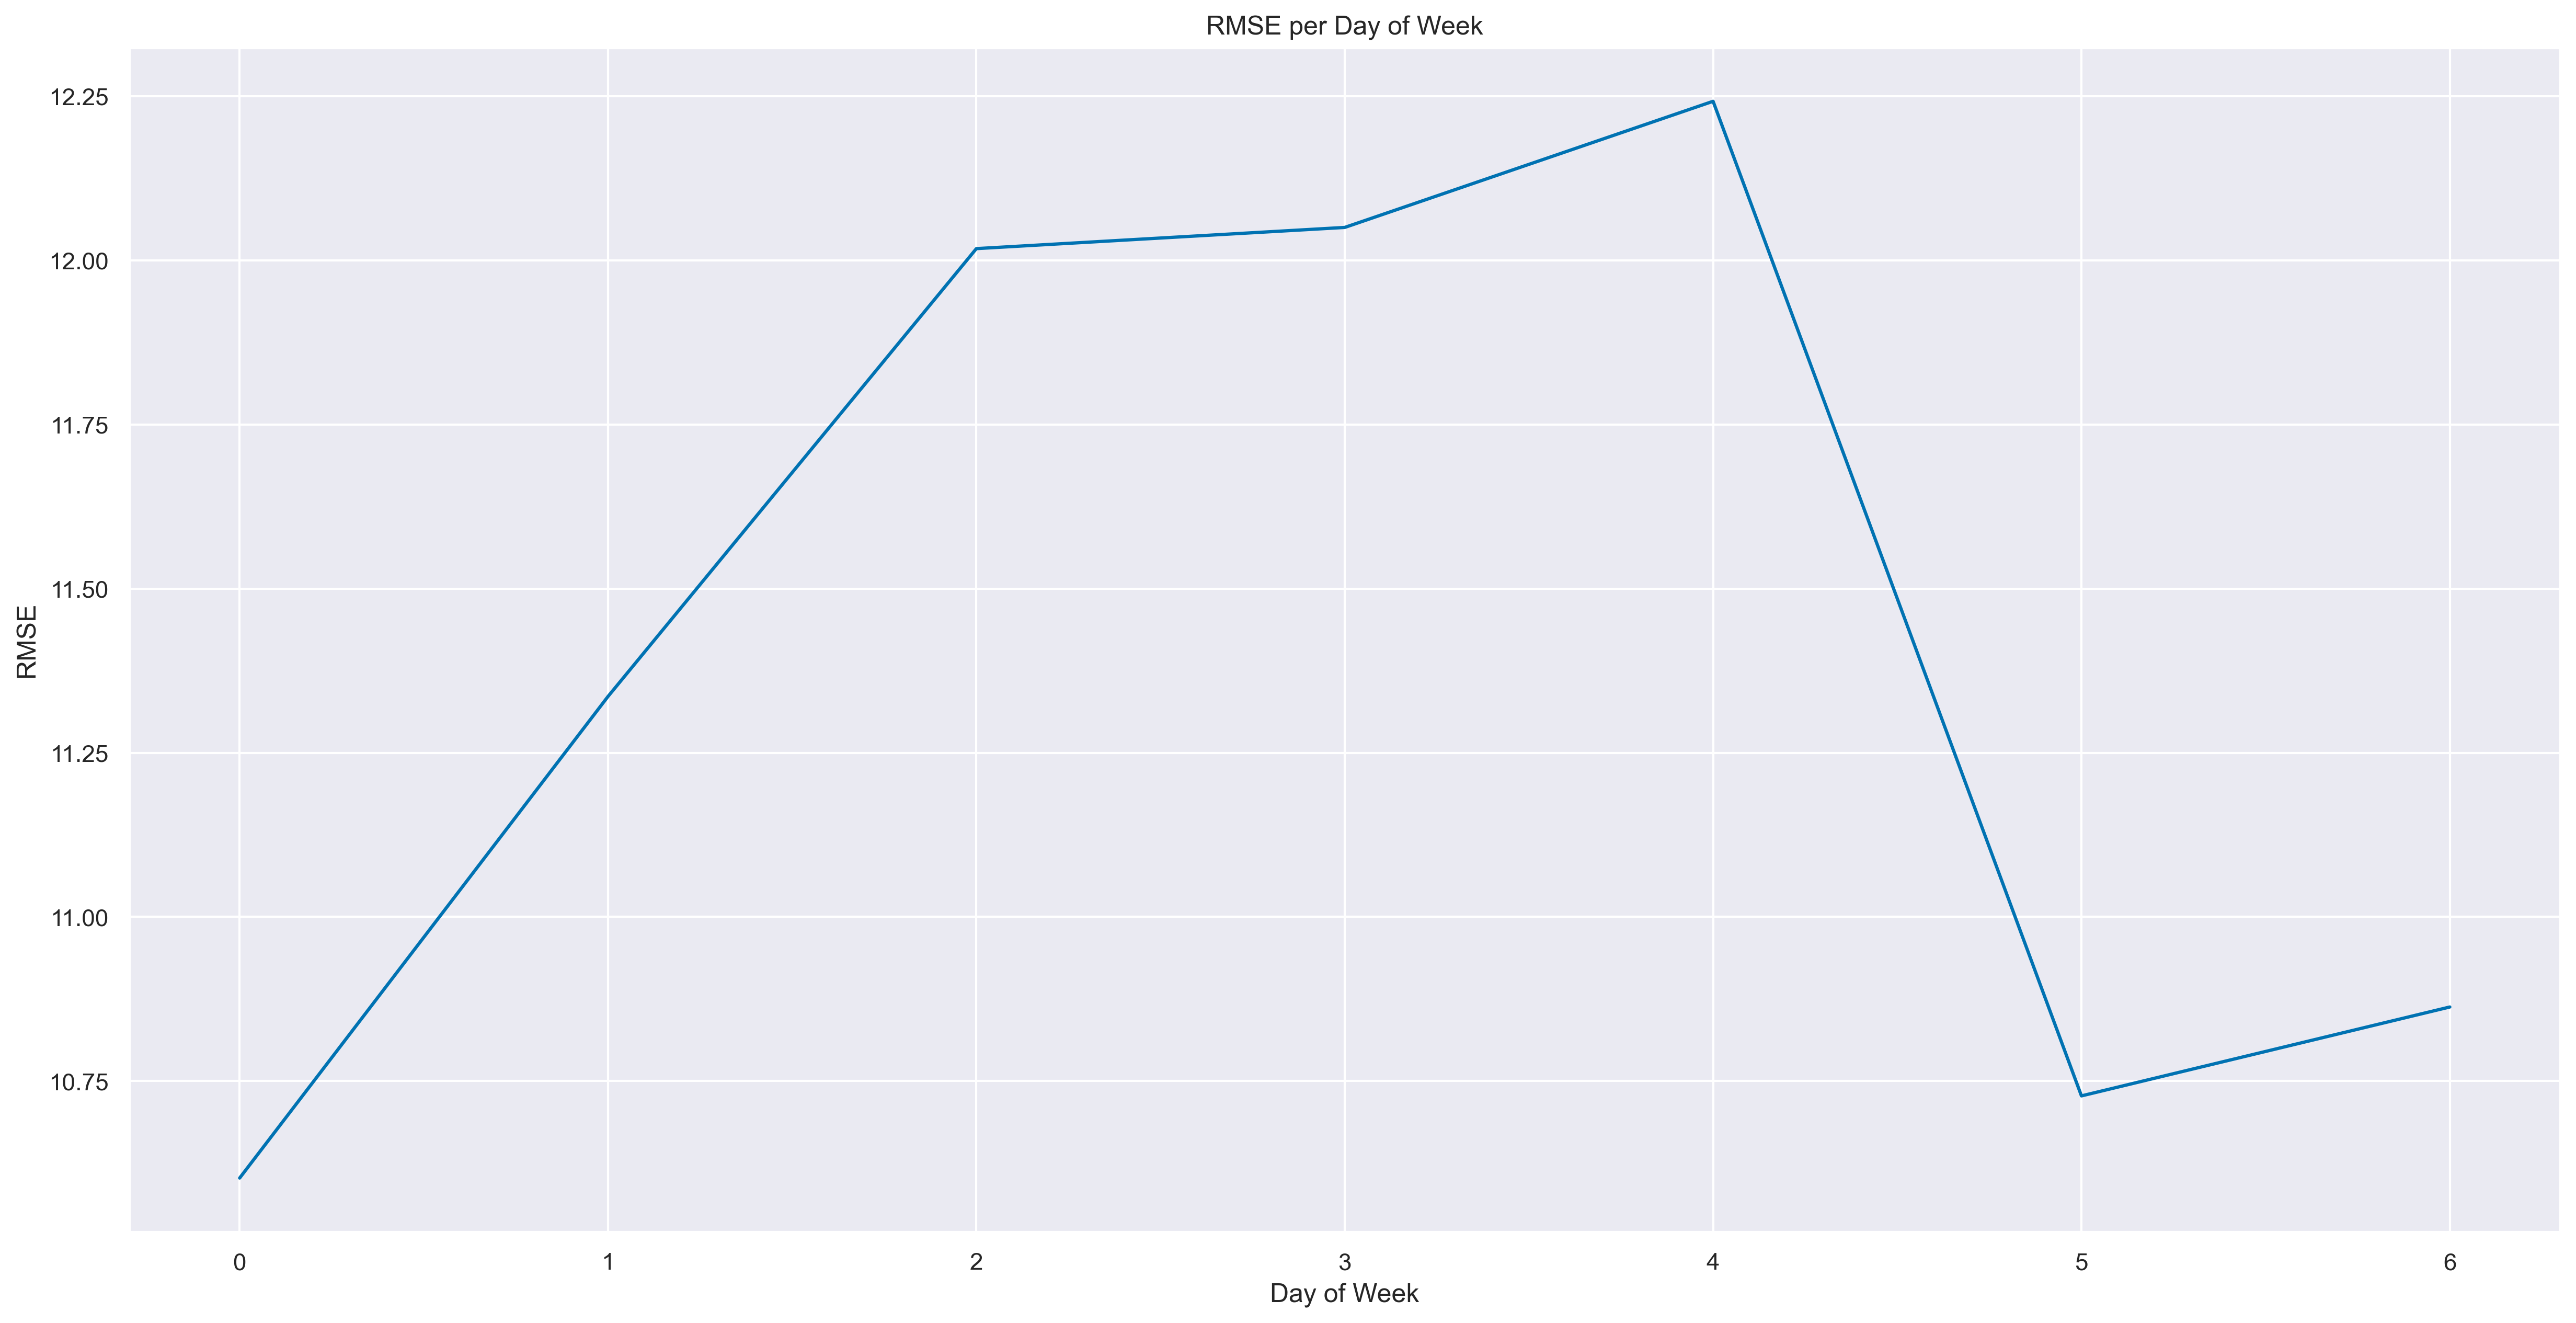

In [23]:
preds_df["dayofweek"] = preds_df["datetime"].dt.dayofweek
weekday_preds = preds_df.groupby("dayofweek")["RMSE"].mean()
display(weekday_preds)
plt.plot(weekday_preds,"C0")
plt.xlabel('Day of Week') 
plt.ylabel('RMSE') 
plt.title("RMSE per Day of Week")
plt.savefig(f'Plots/LSTM_2 Day of Week error.jpg')
plt.show()

dayofweek,0,1,2,3,4,5,6
hour,,,,,,,
0,10.421056,11.136811,11.864464,11.908474,12.139039,10.641317,10.798474
1,10.428391,11.149513,11.872795,11.920283,12.148339,10.648867,10.802311
2,10.437026,11.162818,11.881824,11.931406,12.157044,10.670147,10.808134
3,10.446242,11.176709,11.895490,11.942452,12.165309,10.686347,10.813748
4,10.455967,11.190679,11.920429,11.953221,12.173026,10.699824,10.819512
5,10.463638,11.203742,11.947998,11.963376,12.180835,10.711710,10.826450
6,10.469165,11.216077,11.956178,11.974358,12.189223,10.716296,10.832952
7,10.474645,11.229080,11.966214,11.985892,12.198027,10.719018,10.838545
8,10.492954,11.250049,11.980102,11.998761,12.206785,10.717411,10.843523


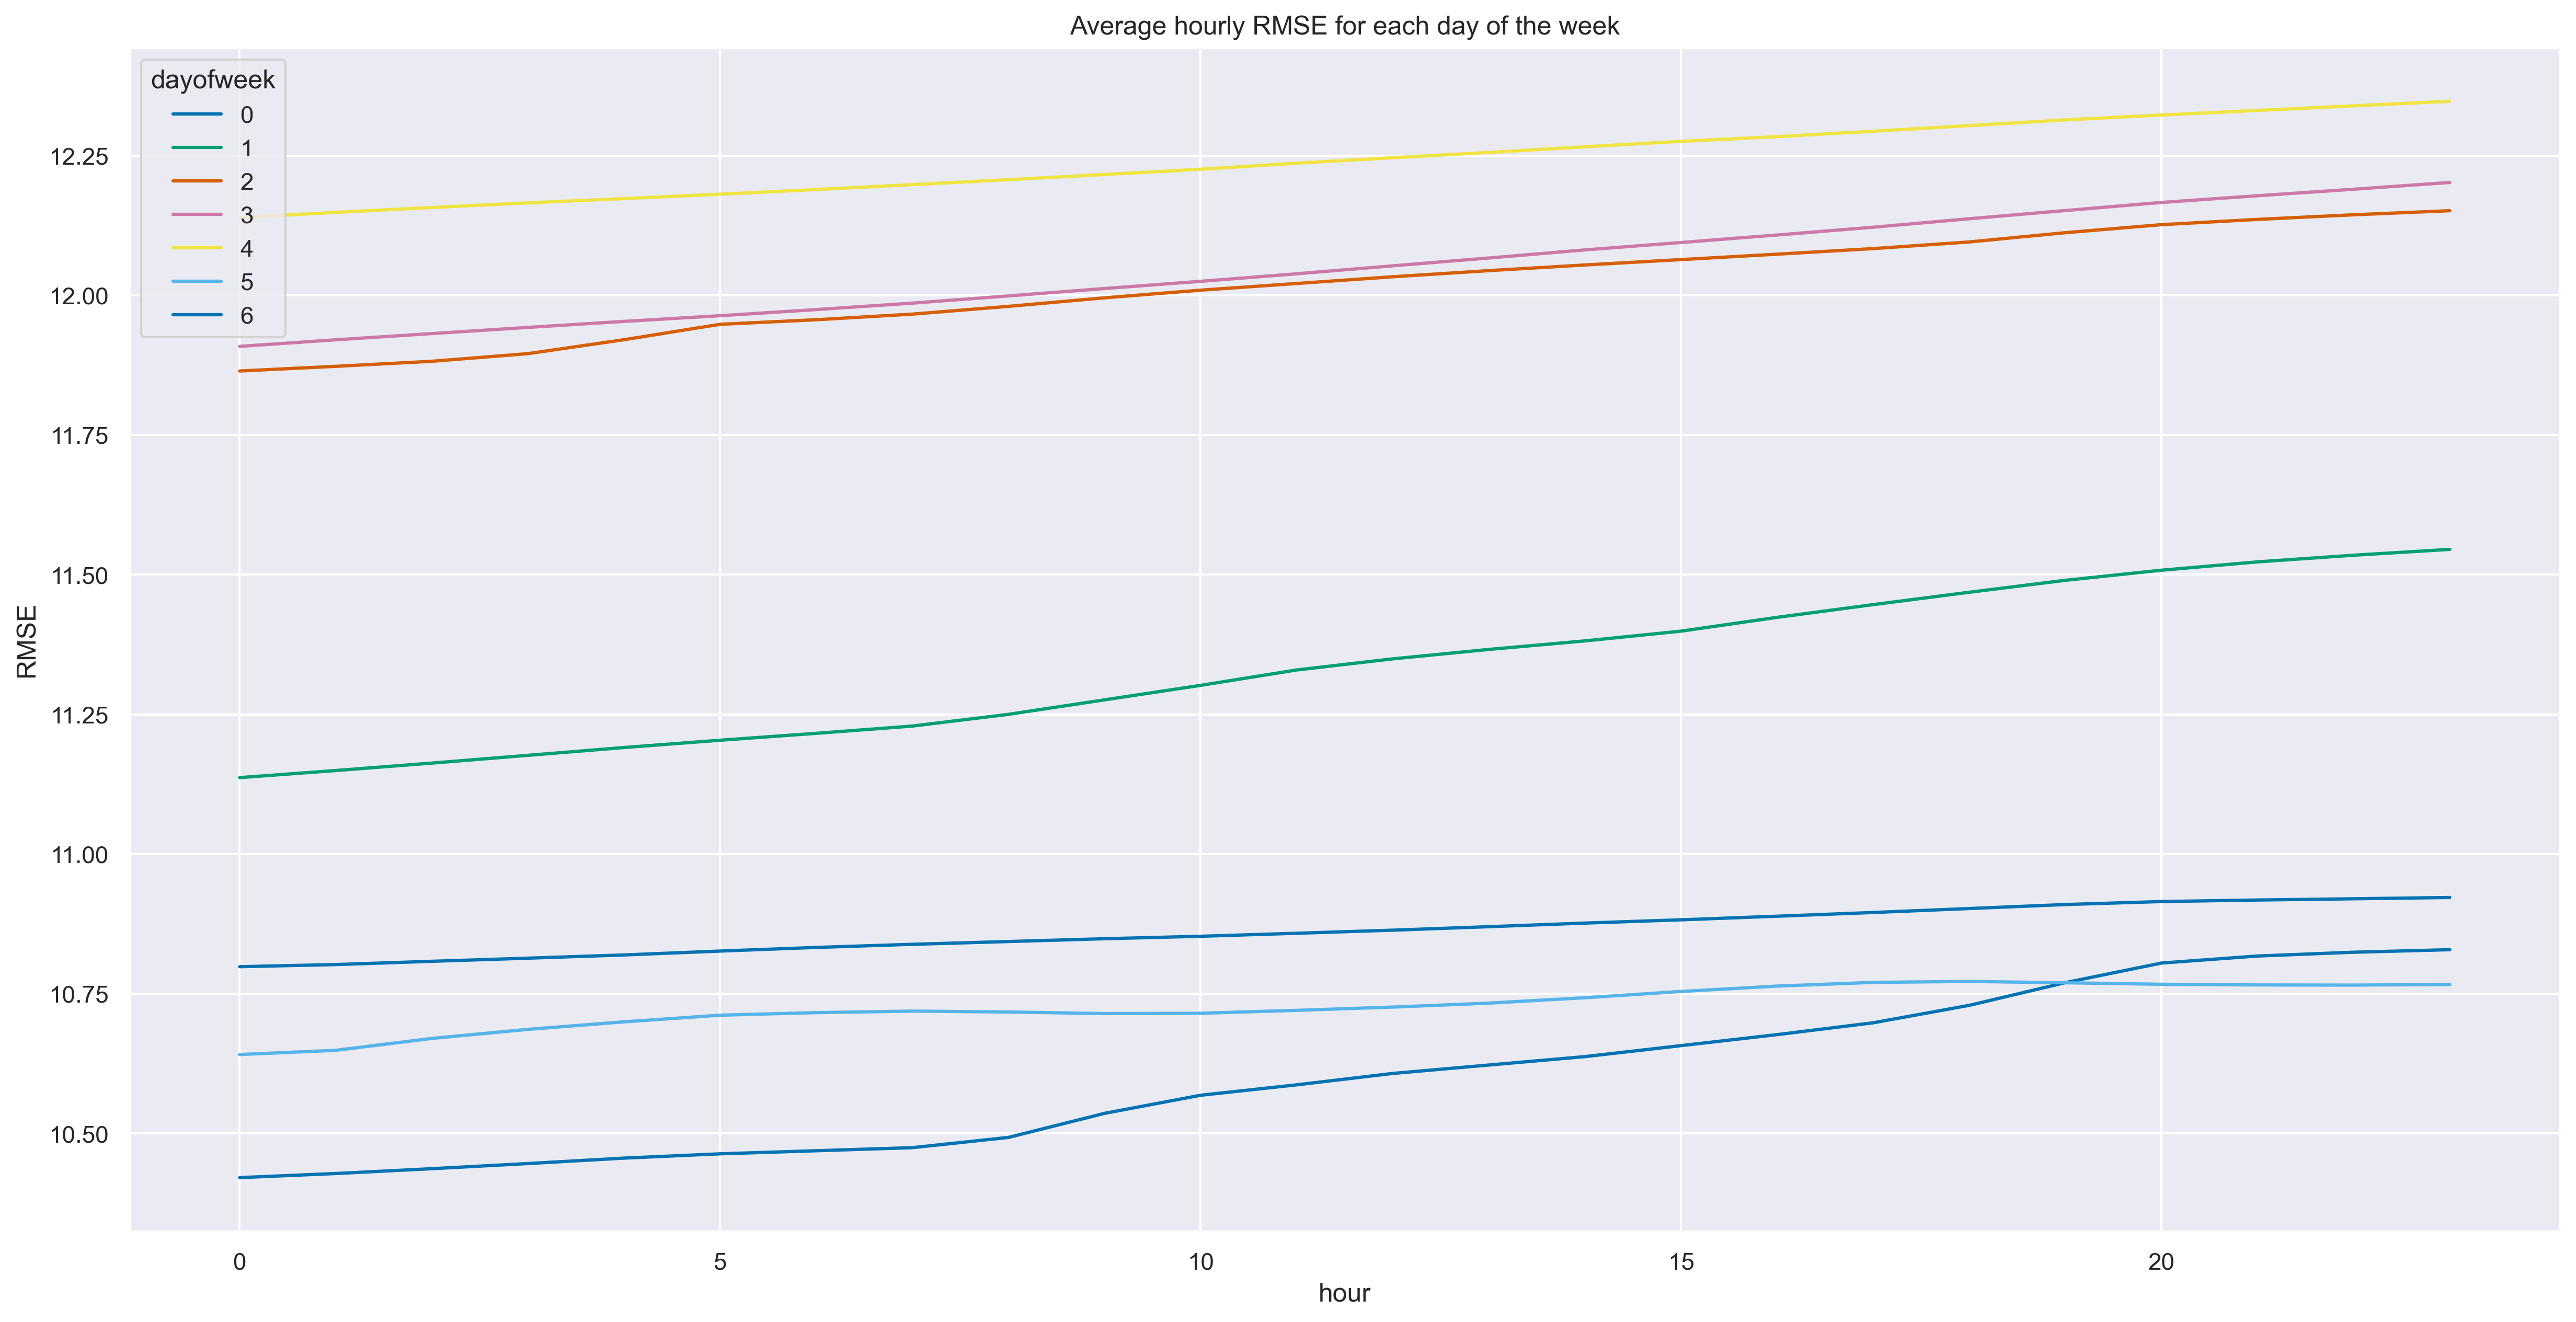

In [24]:
hour_day = pd.pivot_table(data = preds_df, values="RMSE",
                            index = "hour", columns="dayofweek",
                            aggfunc="mean")
display(hour_day)
hour_day.plot()
plt.ylabel("RMSE")
plt.title("Average hourly RMSE for each day of the week")
plt.savefig(f'Plots/LSTM_2 Average hourly RMSE for each day.jpg')
plt.show()